# Prophet Baseline Forecasting for M5 Subset

This notebook trains a Prophet baseline model on the processed M5 subset panel and evaluates forecast accuracy over a 28-day horizon. It also performs a lightweight rolling backtest and multi-item batch evaluation.

In [1]:
# 1. Environment & Imports (Prophet Install / Root Detection / Optional Plotly + ipywidgets)
import importlib, sys, subprocess, json, math
from pathlib import Path

# Robust project root detection (so data path isn't under notebooks/)
NB_PATH = Path(__file__).resolve() if '__file__' in globals() else Path.cwd()
root_candidates = [p for p in NB_PATH.parents if (p / 'README.md').exists() or (p / 'environment.yml').exists()]
PROJECT_ROOT = root_candidates[0] if root_candidates else NB_PATH
print('Detected project root:', PROJECT_ROOT)

# Optional: ensure plotly & ipywidgets (silences Prophet component warnings)
try:
    import plotly  # noqa: F401
except ImportError:
    print('plotly not found; attempting installation (with ipywidgets for notebook support)...')
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'plotly', 'ipywidgets'], check=False)
    try:
        import plotly  # noqa: F401
        print('plotly installed successfully.')
    except Exception as e:
        print('plotly still unavailable:', e)

# Ensure prophet is available
try:
    from prophet import Prophet
except ImportError:
    print('prophet not found; attempting installation...')
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'prophet'], check=False)
    from prophet import Prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
ARTIFACT_DIR = PROJECT_ROOT / 'artifacts'
FIG_DIR = ARTIFACT_DIR / 'figures'
MODEL_DIR = ARTIFACT_DIR / 'models'
for d in [ARTIFACT_DIR, FIG_DIR, MODEL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print('Using data dir:', DATA_DIR)
print('Python version:', sys.version.split()[0])

# If tqdm notebook warning appears (IProgress), advise install if still missing
try:
    import tqdm  # noqa: F401
except Exception:
    print('tqdm import issue detected; you can install/upgrade: pip install --upgrade tqdm ipywidgets jupyterlab')

Detected project root: /Users/zak/Repos/E-commerce-Demand-Forecasting
Using data dir: /Users/zak/Repos/E-commerce-Demand-Forecasting/data/processed
Python version: 3.11.13


In [2]:
# 2. Load Prepared Panel Parquet
panel_path = DATA_DIR / 'm5_panel_subset.parquet'
if not panel_path.exists():
    raise FileNotFoundError(f'Expected prepared panel at {panel_path}. Run data_processing notebook first.')

long = pd.read_parquet(panel_path)
print('Loaded long panel shape:', long.shape)
print('Columns:', long.columns.tolist()[:20])

# Ensure date dtype & sort
if not np.issubdtype(long['date'].dtype, np.datetime64):
    long['date'] = pd.to_datetime(long['date'])
long = long.sort_values('date')

required_cols = {'item_id', 'date', 'demand'}
missing_req = required_cols - set(long.columns)
if missing_req:
    raise ValueError(f'Missing required columns: {missing_req}')

long.head()

Loaded long panel shape: (3826000, 15)
Columns: ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'demand', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'sell_price']


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,date,wm_yr_wk,weekday,wday,month,year,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN
1341,HOBBIES_1_146_TX_3_validation,HOBBIES_1_146,HOBBIES_1,HOBBIES,TX_3,TX,d_1,1,2011-01-29,11101,Saturday,1,1,2011,5.12
1340,HOBBIES_1_145_TX_3_validation,HOBBIES_1_145,HOBBIES_1,HOBBIES,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,NaN
1339,HOBBIES_1_144_TX_3_validation,HOBBIES_1_144,HOBBIES_1,HOBBIES,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,10.48
1338,HOBBIES_1_143_TX_3_validation,HOBBIES_1_143,HOBBIES_1,HOBBIES,TX_3,TX,d_1,0,2011-01-29,11101,Saturday,1,1,2011,7.98


In [3]:
# 3. Select Sample Item & Aggregate Daily Demand
# Pick the item with highest total demand in the subset
item_totals = long.groupby('item_id')['demand'].sum().sort_values(ascending=False)
sample_item_id = item_totals.index[0]
print('Sample item selected:', sample_item_id)

# Aggregate across stores if multiple rows per date
item_df = long[long['item_id'] == sample_item_id]
item_daily = item_df.groupby('date')['demand'].sum().reset_index()
print('Item daily shape:', item_daily.shape)
item_daily.head()

Sample item selected: HOBBIES_1_178
Item daily shape: (1913, 2)


,date,demand
0,2011-01-29,42
1,2011-01-30,63
2,2011-01-31,67
3,2011-02-01,58
4,2011-02-02,23


In [4]:
# 4. Prepare Prophet DataFrame
# Ensure continuous date index (fill missing with 0 demand)
full_range = pd.date_range(item_daily['date'].min(), item_daily['date'].max(), freq='D')
item_daily_full = item_daily.set_index('date').reindex(full_range).fillna(0.0).rename_axis('date').reset_index()

# Add optional regressor: average sell_price across stores for that date
if 'sell_price' in item_df.columns:
    price_daily = item_df.groupby('date')['sell_price'].mean().reindex(full_range)
    item_daily_full['sell_price'] = price_daily.values
    # Forward fill price if initial gaps
    item_daily_full['sell_price'] = item_daily_full['sell_price'].fillna(method='ffill').fillna(method='bfill')
else:
    item_daily_full['sell_price'] = np.nan

prophet_df = item_daily_full.rename(columns={'date': 'ds', 'demand': 'y'})
print('Prophet frame shape:', prophet_df.shape)
prophet_df.head()

Prophet frame shape: (1913, 3)


/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_2870/3422782118.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_daily_full['sell_price'] = item_daily_full['sell_price'].fillna(method='ffill').fillna(method='bfill')


,ds,y,sell_price
0,2011-01-29,42,0.466667
1,2011-01-30,63,0.466667
2,2011-01-31,67,0.466667
3,2011-02-01,58,0.466667
4,2011-02-02,23,0.466667


In [5]:
# 5. Train Prophet Baseline Model
# Formula: y(t) = g(t) + s(t) + h(t) + ε_t, with g trend, s seasonalities, h holidays (unused here)
H = 28  # forecast horizon / test window
train_df = prophet_df.iloc[:-H].copy()
valid_df = prophet_df.iloc[-H:].copy()

m = Prophet(changepoint_range=0.9, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
if 'sell_price' in train_df.columns and not train_df['sell_price'].isna().all():
    m.add_regressor('sell_price')

m.fit(train_df[['ds','y','sell_price']] if 'sell_price' in train_df.columns else train_df[['ds','y']])
print('Model fitted. Training rows:', len(train_df))

15:06:03 - cmdstanpy - INFO - Chain [1] start processing
15:06:03 - cmdstanpy - INFO - Chain [1] done processing


Model fitted. Training rows: 1885


In [6]:
# 6. Create Future DataFrame & Generate Forecast
future = m.make_future_dataframe(periods=H, freq='D')
if 'sell_price' in prophet_df.columns and 'sell_price' in train_df.columns:
    # Merge regressor values for future periods; assume last known price persists
    last_price = train_df['sell_price'].iloc[-1]
    regressor_series = prophet_df.set_index('ds')['sell_price'].reindex(future['ds']).fillna(last_price)
    future['sell_price'] = regressor_series.values

forecast = m.predict(future)
print('Forecast shape:', forecast.shape)
forecast.tail()

Forecast shape: (1913, 25)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1908,2016-04-20,50.181470,20.825217,83.439178,50.138546,50.239706,2.476970,2.476970,2.476970,-1.396173,...,-2.940411,-2.940411,-2.940411,6.813554,6.813554,6.813554,0.0,0.0,0.0,52.658439
1909,2016-04-21,50.182194,22.432777,79.802881,50.128046,50.252829,0.997737,0.997737,0.997737,-1.396173,...,-4.516694,-4.516694,-4.516694,6.910604,6.910604,6.910604,0.0,0.0,0.0,51.179931
1910,2016-04-22,50.182918,28.837208,85.802437,50.110260,50.264098,6.551613,6.551613,6.551613,-1.396173,...,0.974196,0.974196,0.974196,6.973590,6.973590,6.973590,0.0,0.0,0.0,56.734531
1911,2016-04-23,50.183643,41.386714,100.549556,50.099715,50.281689,21.792295,21.792295,21.792295,-1.396173,...,16.190384,16.190384,16.190384,6.998084,6.998084,6.998084,0.0,0.0,0.0,71.975938
1912,2016-04-24,50.184367,25.273834,83.687405,50.093848,50.289364,4.370482,4.370482,4.370482,-1.396173,...,-1.213667,-1.213667,-1.213667,6.980322,6.980322,6.980322,0.0,0.0,0.0,54.554849


Saved forecast plot to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/figures/prophet_forecast_HOBBIES_1_178.png


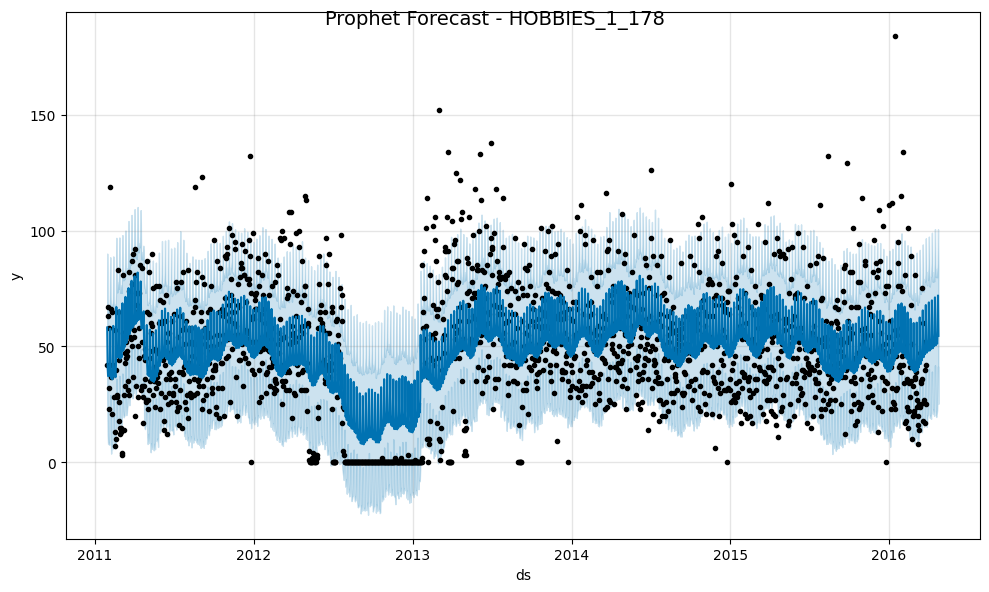

Saved components plot to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/figures/prophet_components_HOBBIES_1_178.png


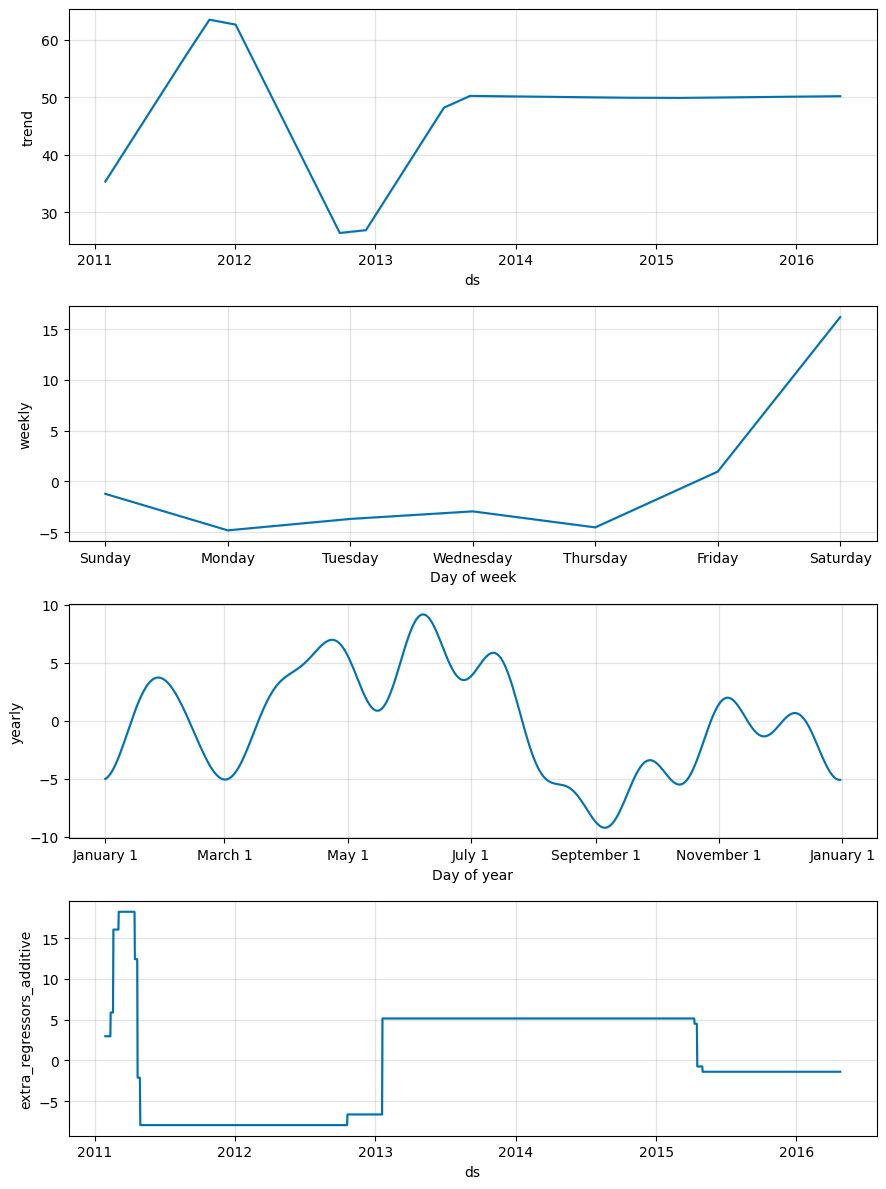

In [7]:
# 7. Plot Forecast & Components
fig_forecast = m.plot(forecast)
fig_forecast.suptitle(f'Prophet Forecast - {sample_item_id}', fontsize=14)
forecast_path = FIG_DIR / f'prophet_forecast_{sample_item_id}.png'
fig_forecast.savefig(forecast_path)
print('Saved forecast plot to', forecast_path)
plt.show()
plt.close(fig_forecast)

fig_components = m.plot_components(forecast)
components_path = FIG_DIR / f'prophet_components_{sample_item_id}.png'
fig_components.savefig(components_path)
print('Saved components plot to', components_path)
plt.show()
plt.close(fig_components)

In [8]:
# 8. Define Evaluation Metrics (RMSE, MAE, MAPE, sMAPE, WAPE)
EPS = 1e-8

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def mae(a, b):
    return mean_absolute_error(a, b)

def mape(a, b):
    a = np.array(a); b = np.array(b)
    return 100.0 * np.mean(np.abs(a - b) / (np.abs(a) + EPS))

def smape(a, b):
    a = np.array(a); b = np.array(b)
    return 100.0 * np.mean(np.abs(a - b) / ((np.abs(a) + np.abs(b)) / 2.0 + EPS))

def wape(a, b):
    a = np.array(a); b = np.array(b)
    denom = np.sum(np.abs(a))
    return np.nan if denom == 0 else 100.0 * np.sum(np.abs(a - b)) / denom

# Forecast Accuracy (portfolio style) often defined as 100 - WAPE
print('Metric functions ready (RMSE, MAE, MAPE, sMAPE, WAPE).')

Metric functions ready (RMSE, MAE, MAPE, sMAPE, WAPE).


In [9]:
# 9. Train/Test Split & Single Item Evaluation
# Align forecast with validation portion
forecast_valid = forecast.set_index('ds').loc[valid_df['ds']]
actual = valid_df.set_index('ds')['y']

wape_val = wape(actual, forecast_valid['yhat'])
metrics_single = {
    'item_id': sample_item_id,
    'rmse': rmse(actual, forecast_valid['yhat']),
    'mae': mae(actual, forecast_valid['yhat']),
    'mape': mape(actual, forecast_valid['yhat']),
    'smape': smape(actual, forecast_valid['yhat']),
    'wape': wape_val,
    'forecast_accuracy': 100.0 - wape_val,
}
print('Single item validation metrics:')
print(json.dumps(metrics_single, indent=2))

single_metrics_path = ARTIFACT_DIR / f'prophet_metrics_{sample_item_id}.json'
with open(single_metrics_path, 'w') as f:
    json.dump(metrics_single, f)
print('Saved single item metrics to', single_metrics_path)

Single item validation metrics:
{
  "item_id": "HOBBIES_1_178",
  "rmse": 20.730811037587532,
  "mae": 18.225824804016003,
  "mape": 61.241080971280105,
  "smape": 42.62848880142583,
  "wape": 45.80997257741904,
  "forecast_accuracy": 54.19002742258096
}
Saved single item metrics to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/prophet_metrics_HOBBIES_1_178.json


In [10]:
# 10. Rolling Cutoff Backtest (Cross-Validation)
# Simple custom rolling window: last N*H days stepping by H
N_WINDOWS = 5  # number of backtest windows
cutoff_dates = list(train_df['ds'].iloc[-(N_WINDOWS*H)::H])
backtest_rows = []

for cutoff in cutoff_dates:
    hist = prophet_df[prophet_df['ds'] <= cutoff]
    # Skip if not enough history
    if len(hist) < 100:
        continue
    m_bt = Prophet(changepoint_range=0.9, weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    if 'sell_price' in hist.columns and not hist['sell_price'].isna().all():
        m_bt.add_regressor('sell_price')
    m_bt.fit(hist[['ds','y','sell_price']] if 'sell_price' in hist.columns else hist[['ds','y']])
    future_bt = m_bt.make_future_dataframe(periods=H, freq='D')
    if 'sell_price' in hist.columns and 'sell_price' in prophet_df.columns:
        last_price = hist['sell_price'].iloc[-1]
        reg_s = prophet_df.set_index('ds')['sell_price'].reindex(future_bt['ds']).fillna(last_price)
        future_bt['sell_price'] = reg_s.values
    fc_bt = m_bt.predict(future_bt)
    fc_slice = fc_bt.set_index('ds').iloc[-H:]
    actual_slice = prophet_df.set_index('ds').loc[fc_slice.index]['y']
    wape_bt = wape(actual_slice, fc_slice['yhat'])
    bt_metrics = {
        'cutoff': str(cutoff.date()),
        'rmse': rmse(actual_slice, fc_slice['yhat']),
        'mae': mae(actual_slice, fc_slice['yhat']),
        'mape': mape(actual_slice, fc_slice['yhat']),
        'smape': smape(actual_slice, fc_slice['yhat']),
        'wape': wape_bt,
        'forecast_accuracy': 100.0 - wape_bt,
    }
    backtest_rows.append(bt_metrics)

backtest_df = pd.DataFrame(backtest_rows)
print('Backtest windows:', len(backtest_df))
backtest_df

15:06:04 - cmdstanpy - INFO - Chain [1] start processing
15:06:04 - cmdstanpy - INFO - Chain [1] done processing
15:06:05 - cmdstanpy - INFO - Chain [1] start processing
15:06:05 - cmdstanpy - INFO - Chain [1] done processing
15:06:05 - cmdstanpy - INFO - Chain [1] start processing
15:06:05 - cmdstanpy - INFO - Chain [1] done processing
15:06:06 - cmdstanpy - INFO - Chain [1] start processing
15:06:06 - cmdstanpy - INFO - Chain [1] done processing
15:06:06 - cmdstanpy - INFO - Chain [1] start processing
15:06:06 - cmdstanpy - INFO - Chain [1] done processing


Backtest windows: 5


,cutoff,rmse,mae,mape,smape,wape,forecast_accuracy
0,2015-11-09,21.899001,17.777446,3.391430e+01,33.787755,32.877707,67.122293
1,2015-12-07,25.523413,18.840894,1.635756e+10,38.452514,34.013219,65.986781
2,2016-01-04,30.315678,20.020102,3.669969e+01,33.300449,34.390359,65.609641
3,2016-02-01,29.380088,24.291716,9.565592e+01,54.882240,57.349750,42.650250
4,2016-02-29,26.897034,25.083487,1.106219e+02,62.563386,76.010566,23.989434


In [11]:
# 11. Batch Prophet Fits for Multiple Items
TOP_K = 25
item_ranked = item_totals.index[:TOP_K]
item_metric_rows = []

for itm in item_ranked:
    df_item = long[long['item_id'] == itm]
    daily_item = df_item.groupby('date')['demand'].sum().reset_index()
    full_range = pd.date_range(daily_item['date'].min(), daily_item['date'].max(), freq='D')
    daily_full = daily_item.set_index('date').reindex(full_range).fillna(0.0).rename_axis('date').reset_index()
    if 'sell_price' in df_item.columns:
        price_series = df_item.groupby('date')['sell_price'].mean().reindex(full_range)
        daily_full['sell_price'] = price_series.values
        daily_full['sell_price'] = daily_full['sell_price'].fillna(method='ffill').fillna(method='bfill')
    prophet_item = daily_full.rename(columns={'date':'ds','demand':'y'})
    if len(prophet_item) <= H:
        continue
    train_item = prophet_item.iloc[:-H]
    valid_item = prophet_item.iloc[-H:]
    m_item = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)
    if 'sell_price' in prophet_item.columns and not prophet_item['sell_price'].isna().all():
        m_item.add_regressor('sell_price')
    m_item.fit(train_item[['ds','y','sell_price']] if 'sell_price' in train_item.columns else train_item[['ds','y']])
    future_item = m_item.make_future_dataframe(periods=H, freq='D')
    if 'sell_price' in prophet_item.columns and 'sell_price' in train_item.columns:
        last_price = train_item['sell_price'].iloc[-1]
        reg_series = prophet_item.set_index('ds')['sell_price'].reindex(future_item['ds']).fillna(last_price)
        future_item['sell_price'] = reg_series.values
    fc_item = m_item.predict(future_item)
    fc_valid = fc_item.set_index('ds').iloc[-H:]
    act_valid = valid_item.set_index('ds')['y']
    wape_item = wape(act_valid, fc_valid['yhat'])
    row_metrics = {
        'item_id': itm,
        'rmse': rmse(act_valid, fc_valid['yhat']),
        'mae': mae(act_valid, fc_valid['yhat']),
        'mape': mape(act_valid, fc_valid['yhat']),
        'smape': smape(act_valid, fc_valid['yhat']),
        'wape': wape_item,
        'forecast_accuracy': 100.0 - wape_item,
        'n_history': len(train_item),
    }
    item_metric_rows.append(row_metrics)

multi_item_metrics = pd.DataFrame(item_metric_rows)
print('Multi-item metrics shape:', multi_item_metrics.shape)
multi_item_metrics.head()

/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_2870/2291833315.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_full['sell_price'] = daily_full['sell_price'].fillna(method='ffill').fillna(method='bfill')
15:06:06 - cmdstanpy - INFO - Chain [1] start processing
15:06:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_2870/2291833315.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_full['sell_price'] = daily_full['sell_price'].fillna(method='ffill').fillna(method='bfill')
15:06:07 - cmdstanpy - INFO - Chain [1] start processing
15:06:07 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/c5/09trk0mj389dhs59ptvs9f8h0000gn/T/ipykernel_2870/2291833315.py:14: FutureWarning: Series.fillna with 'method' is deprecated and w

Multi-item metrics shape: (25, 8)


,item_id,rmse,mae,mape,smape,wape,forecast_accuracy,n_history
0,HOBBIES_1_178,17.315130,13.876285,46.046138,34.705846,34.877556,65.122444,1885
1,HOBBIES_1_008,18.018151,13.613618,36.910796,32.932924,33.762736,66.237264,1885
2,HOBBIES_1_015,11.203662,10.231559,44.391605,33.614453,32.045151,67.954849,1885
3,HOBBIES_1_048,22.370097,18.448430,26.881422,25.019733,24.562817,75.437183,1885
4,HOBBIES_1_103,12.347971,10.551105,34.594095,30.403445,28.516501,71.483499,1885


Top 5 items by sMAPE (lower is better):
          item_id      smape       wape  forecast_accuracy       rmse  \
21  HOBBIES_1_158  22.106108  22.421229          77.578771  14.489692   
18  HOBBIES_1_142  23.332948  22.861635          77.138365   5.116394   
8   HOBBIES_1_189  23.975149  23.931540          76.068460  16.677806   
3   HOBBIES_1_048  25.019733  24.562817          75.437183  22.370097   
13  HOBBIES_1_147  25.562408  24.637139          75.362861   8.365927   

          mae  
21  12.051410  
18   4.196743  
8   12.034146  
3   18.448430  
13   6.467249  

Metrics summary (including WAPE & Forecast Accuracy):
           smape       wape  forecast_accuracy       rmse        mae  \
count  25.000000  25.000000          25.000000  25.000000  25.000000   
mean   35.535161  35.548054          64.451946  12.751420  10.221939   
std    10.003607  11.198923          11.198923   5.993356   4.746171   
min    22.106108  22.421229          39.873559   4.243090   3.339672   
25%    27.

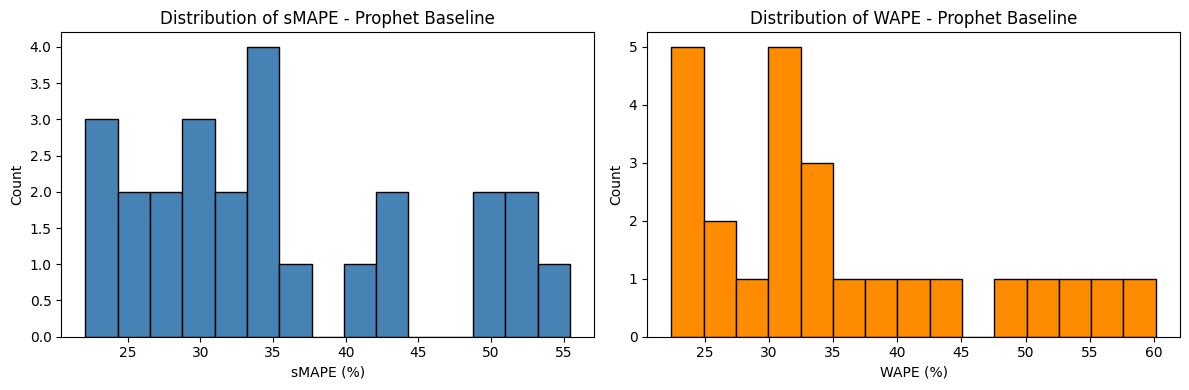

In [12]:
# 12. Collect & Rank Item-Level Metrics
if not multi_item_metrics.empty:
    # Rank primarily by sMAPE, show WAPE and forecast accuracy summary
    multi_item_metrics = multi_item_metrics.sort_values('smape')
    print('Top 5 items by sMAPE (lower is better):')
    print(multi_item_metrics[['item_id','smape','wape','forecast_accuracy','rmse','mae']].head())
    print('\nMetrics summary (including WAPE & Forecast Accuracy):')
    print(multi_item_metrics[['smape','wape','forecast_accuracy','rmse','mae','mape']].describe())
    # Plot distribution of sMAPE and WAPE side by side
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    axes[0].hist(multi_item_metrics['smape'], bins=15, color='steelblue', edgecolor='black')
    axes[0].set_title('Distribution of sMAPE - Prophet Baseline')
    axes[0].set_xlabel('sMAPE (%)'); axes[0].set_ylabel('Count')
    axes[1].hist(multi_item_metrics['wape'], bins=15, color='darkorange', edgecolor='black')
    axes[1].set_title('Distribution of WAPE - Prophet Baseline')
    axes[1].set_xlabel('WAPE (%)'); axes[1].set_ylabel('Count')
    fig.tight_layout()
    dist_path = FIG_DIR / 'prophet_smape_wape_distribution.png'
    fig.savefig(dist_path)
    print('Saved sMAPE & WAPE distribution plot to', dist_path)
    plt.show(); plt.close(fig)
else:
    print('No multi-item metrics computed (multi_item_metrics empty).')

In [13]:
# 13. Persist Forecasts & Metrics Artifacts
# Save multi-item metrics
metrics_path_parquet = ARTIFACT_DIR / 'metrics_prophet_baseline.parquet'
metrics_path_json = ARTIFACT_DIR / 'metrics_prophet_baseline.json'

if not multi_item_metrics.empty:
    multi_item_metrics.to_parquet(metrics_path_parquet, index=False)
    with open(metrics_path_json, 'w') as f:
        json.dump(multi_item_metrics.to_dict(orient='records'), f)
    print('Saved metrics to', metrics_path_parquet, 'and', metrics_path_json)

# Save backtest results
backtest_path = ARTIFACT_DIR / 'backtest_prophet_baseline.parquet'
if not backtest_df.empty:
    backtest_df.to_parquet(backtest_path, index=False)
    print('Saved backtest results to', backtest_path)

# Save single item forecast for validation horizon
single_fc_out = ARTIFACT_DIR / f'forecast_{sample_item_id}_prophet.parquet'
forecast_valid[['yhat','yhat_lower','yhat_upper']].to_parquet(single_fc_out)
print('Saved single item validation forecast to', single_fc_out)

# Dump model parameters (trend changepoints)
params_path = MODEL_DIR / f'prophet_model_params_{sample_item_id}.json'
model_info = {
    'item_id': sample_item_id,
    'changepoints': [str(cp.date()) for cp in m.changepoints],
    'n_changepoints': len(m.changepoints),
    'seasonality_modes': 'additive',
    'weekly_seasonality': True,
    'yearly_seasonality': True,
}
with open(params_path, 'w') as f:
    json.dump(model_info, f)
print('Saved model params to', params_path)

Saved metrics to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/metrics_prophet_baseline.parquet and /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/metrics_prophet_baseline.json
Saved backtest results to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/backtest_prophet_baseline.parquet
Saved single item validation forecast to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/forecast_HOBBIES_1_178_prophet.parquet
Saved model params to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/models/prophet_model_params_HOBBIES_1_178.json


In [14]:
# 14. Aggregate Multi-Item Metrics Summary & Persist
import json
summary_out = ARTIFACT_DIR / 'prophet_multi_item_summary.json'
metrics_parquet = ARTIFACT_DIR / 'metrics_prophet_baseline.parquet'
backtest_parquet = ARTIFACT_DIR / 'backtest_prophet_baseline.parquet'

summary = {}
if metrics_parquet.exists():
    multi_df = pd.read_parquet(metrics_parquet)
    # Basic aggregates
    agg = multi_df[['rmse','mae','mape','smape','wape','forecast_accuracy']].mean().to_dict()
    summary['multi_item_mean'] = {k: float(v) for k,v in agg.items()}
    summary['n_items'] = int(len(multi_df))
else:
    summary['multi_item_mean'] = None
    summary['n_items'] = 0

if backtest_parquet.exists():
    bt_df = pd.read_parquet(backtest_parquet)
    bt_agg = bt_df[['rmse','mae','mape','smape','wape','forecast_accuracy']].mean().to_dict()
    summary['backtest_mean'] = {k: float(v) for k,v in bt_agg.items()}
    summary['n_backtest_windows'] = int(len(bt_df))
else:
    summary['backtest_mean'] = None
    summary['n_backtest_windows'] = 0

# Single item metrics
single_candidates = list(ARTIFACT_DIR.glob('prophet_metrics_*.json'))
if single_candidates:
    # pick first
    with open(single_candidates[0]) as f:
        summary['single_item'] = json.load(f)
else:
    summary['single_item'] = None

with open(summary_out,'w') as f:
    json.dump(summary,f,indent=2)
print('Saved summary to', summary_out)
print(json.dumps(summary, indent=2))

Saved summary to /Users/zak/Repos/E-commerce-Demand-Forecasting/artifacts/prophet_multi_item_summary.json
{
  "multi_item_mean": {
    "rmse": 12.751420244692385,
    "mae": 10.221938561529882,
    "mape": 50.99764011425625,
    "smape": 35.53516079117753,
    "wape": 35.54805397324738,
    "forecast_accuracy": 64.45194602675262
  },
  "n_items": 25,
  "backtest_mean": {
    "rmse": 26.80304278385912,
    "mae": 21.20272879481589,
    "mape": 3271511619.9382505,
    "smape": 44.59726854504471,
    "wape": 46.92832026050632,
    "forecast_accuracy": 53.071679739493675
  },
  "n_backtest_windows": 5,
  "single_item": {
    "item_id": "HOBBIES_1_178",
    "rmse": 20.730811037587532,
    "mae": 18.225824804016003,
    "mape": 61.241080971280105,
    "smape": 42.62848880142583,
    "wape": 45.80997257741904,
    "forecast_accuracy": 54.19002742258096
  }
}
